### KDD 2022 Hands-on Tutorial on "Gradual AutoML using Lale"

# 6. Multi-objective AutoML with Lale

This notebook presents how we can perform a multi-objective refinement of a pipeline found by AutoML utilizing a multi-objective optimizer.
First, we will find a pipeline via single-objective AutoML.
Then we will optimize the final estimator in the pipeline with a multi-objective optimizer to get a Pareto-front of pipelines.

This notebook has the following sections:

- [6.1 Pre-requisites](#6.1-Pre-requisites)
- [6.2 Dataset](#6.1-Dataset)
- [6.3 Single Objective AutoML](#6.3-Single-Objective-AutoML)
- [6.4 Specifying Objectives for Multi-objective AutoML](#6.4-Specifying-Objectives-for-Multi-objective-AutoML)
- [6.5 Multi-objective AutoML Refinement](#6.5-Multi-objective-AutoML-Refinement)
- [6.6 Pareto-front of Multi-objective AutoML](#6.6-Pareto-front-of-Multi-objective-AutoML)


## 6.1 Pre-requisites

We will require the following packages to be additionally installed for this notebook:
- `lalegpl`: This can be installed directly from [IBM/lale-gpl](https://github.com/IBM/lale-gpl) with the following: 

```
pip install git+https://github.com/IBM/lale-gpl.git@master

```
- `Platypus-opt==1.0.4`: This package provides an implementation of the multi-objective **NSGA2** algorithm.

```
pip install Platypus-opt==1.0.4

```

## 6.2 Dataset

We will use the
[credit-g](https://www.openml.org/search?type=data&status=active&id=31)
dataset from OpenML for our running example.
Let's fetch it and inspect its size.

In [1]:
import lale.datasets.openml
import lale.helpers
(train_X, train_y), (test_X, test_y) = \
    lale.datasets.openml.fetch('credit-g', 'classification', preprocess=False)
print(f'train_X.shape {train_X.shape}, train_y.shape {train_y.shape}')

train_X.shape (670, 20), train_y.shape (670,)


In [2]:
import pandas as pd
import numpy as np
pd.options.display.max_columns = None
NROWS = 8
df = pd.concat([train_y.tail(NROWS), train_X.tail(NROWS)], axis=1)
display(df.style.highlight_null('yellow'))

,class,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
359,bad,<0,30.000000,existing paid,furniture/equipment,2406.000000,<100,4<=X<7,4.000000,female div/dep/mar,none,4.000000,real estate,23.000000,none,rent,1.000000,skilled,1.000000,none,yes
707,bad,0<=X<200,12.000000,no credits/all paid,furniture/equipment,2969.000000,<100,<1,4.000000,female div/dep/mar,none,3.000000,life insurance,25.000000,none,rent,2.000000,skilled,1.000000,none,yes
763,bad,no checking,21.000000,critical/other existing credit,new car,12680.000000,no known savings,>=7,4.000000,male single,none,4.000000,no known property,30.000000,none,for free,1.000000,high qualif/self emp/mgmt,1.000000,yes,yes
835,bad,<0,12.000000,no credits/all paid,new car,1082.000000,<100,1<=X<4,4.000000,male single,none,4.000000,car,48.000000,bank,own,2.000000,skilled,1.000000,none,yes
192,bad,0<=X<200,27.000000,existing paid,business,3915.000000,<100,1<=X<4,4.000000,male single,none,2.000000,car,36.000000,none,own,1.000000,skilled,2.000000,yes,yes
629,good,no checking,9.000000,existing paid,education,3832.000000,no known savings,>=7,1.000000,male single,none,4.000000,real estate,64.000000,none,own,1.000000,unskilled resident,1.000000,none,yes
559,bad,0<=X<200,18.000000,critical/other existing credit,furniture/equipment,1928.000000,<100,<1,2.000000,male single,none,2.000000,real estate,31.000000,none,own,2.000000,unskilled resident,1.000000,none,yes
684,good,0<=X<200,36.000000,delayed previously,business,9857.000000,100<=X<500,4<=X<7,1.000000,male single,none,3.000000,life insurance,31.000000,none,own,2.000000,unskilled resident,2.000000,yes,yes


## 6.3 Single-objective AutoML

In this subsection, we will create a small pipeline search space and auto-configure the pipeline by optimizing for the [balanced accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html).

In [3]:
from lale.lib.sklearn import Normalizer as Norm
from lale.lib.sklearn import OneHotEncoder as OneHot
from lale.lib.sklearn import SimpleImputer
from lale.lib.sklearn import LogisticRegression as LR
from lale.lib.sklearn import GradientBoostingClassifier as GB
from lale.lib.sklearn import RandomForestClassifier as RF
from lale.lib.xgboost import XGBClassifier as XGBoost
from lale.lib.lale import Project, ConcatFeatures, NoOp

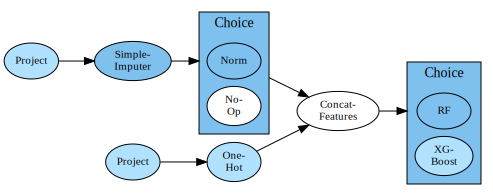

In [4]:
project_nums = Project(columns={'type': 'number'})
project_cats = Project(columns={'type': 'string'})
planned_pipeline = (
    (
        (project_nums >> SimpleImputer >> (Norm | NoOp))
        & (project_cats >> OneHot(handle_unknown='ignore'))
    )
    >> ConcatFeatures
    >> (RF | XGBoost(objective='binary:hinge'))
)
planned_pipeline.visualize()

In [5]:
import sklearn.metrics
from lale.lib.lale import Hyperopt
auto_trained = planned_pipeline.auto_configure(
    train_X, train_y,
    Hyperopt, 
    cv=2,
    max_evals=5,
    scoring='balanced_accuracy',
)
auto_y = auto_trained.predict(test_X)
acc = sklearn.metrics.balanced_accuracy_score(test_y, auto_y)
print(f'balanced accuracy {acc:.1%}')

100%|██████████| 5/5 [00:07<00:00,  1.44s/trial, best loss: -0.6405579399141631]
balanced accuracy 68.8%


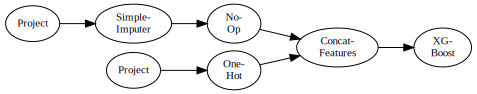

In [6]:
auto_trained.visualize()

## 6.4 Specifying Objectives for Multi-objective AutoML

While we obtained a pipeline by optimizing for balanced accuracy, there might be an application where we wish to simultaneously optimize for balanced accuracy and [symmetric disparate impact](https://lale.readthedocs.io/en/latest/modules/lale.lib.aif360.util.html#lale.lib.aif360.util.symmetric_disparate_impact), and select a pipeline from the set of pipelines with the best tradeoff between those two.
Here we define a scikit-learn scorer for symmetric disparate impact and evaluate the multiple objectives or scores (balanced accuracy and symmetric disparate impact) of the pipeline found above.

In [7]:
from sklearn.metrics import make_scorer, get_scorer

from lale.lib.aif360 import symmetric_disparate_impact
di_scorer = symmetric_disparate_impact(
    favorable_labels=['good'],
    protected_attributes=[{'feature': 'age', 'reference_group': [[26, 1000]]}]
)

# Specify scoring arguments passed to Multi-objective Optimizer
scoring = ['balanced_accuracy', di_scorer]  
best_score = [1, 1]

# Let's also get scorers to compute the metrics value on optimizer's outputs
scorers = [get_scorer(scorer) for scorer in scoring]
print("Metric values using single-objective best pipeline: " +
      ", ".join(f"{s(auto_trained, test_X, test_y):.3f}" for s in scorers))

pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[LFR]'


Metric values using single-objective best pipeline: 0.688, 0.848


## 6.5 Multi-objective AutoML Refinement

Given our two objectives, here we will demonstrate how we can perform a multi-objective refinement of the pipeline found above with Lale. We will optimize the hyperparameters of the final estimator in the pipeline in a multi-objective manner while keeping the hyperparameters of the remaining pipeline fixed. 

For this, we will make use of the `lale.lib.lale.OptimizeLast` operator from Lale and the `NSGA2` multi-objective optimizer wrapper from Lale-GPL. Please refer to [6.1 Pre-requisites](#6.1-Pre-requisites) to ensure that the necessary packages are installed. Otherwise the following import from `lalegpl` will fail.

In [8]:
try:
    from lalegpl.lib.lale import NSGA2
except ImportError:
    import sys
    print("lale-gpl not installed, the remaining notebook will be skipped", file=sys.stderr)
    sys.exit(0)

from lale.lib.lale import OptimizeLast

Here we specify the arguments for the multi-objective optimization such as the scoring functions for the two objectives, the optimal values for the two objectives, and optimizer specific parameters. 

Then we create an instance of the `OptimizeLast` operator that takes as input the (i) original pipeline, (ii) the optimizer, and (iii) the optimizer arugments.

In [9]:
# Create operator for performing MOO on final estimator of best pipeline from single obj optimizer 
optFinalEstimator = OptimizeLast(
    estimator=auto_trained,
    last_optimizer=NSGA2,
    optimizer_args={
        'scoring' : scoring,
        'best_score': best_score,
        'cv' : 2,
        'max_evals' : 40,
        'population_size' : 15,
    }
)

The `OptimizeLast` operator has a `fit` method that executes the multi-objective AutoML.

In [10]:
%%time
opt_trained = optFinalEstimator.fit(train_X, train_y)

CPU times: user 1min 3s, sys: 114 ms, total: 1min 3s
Wall time: 1min 3s


Note that the above optimization does not return a single pipeline but rather a set of Pareto-optimal pipelines that span the tradeoff between the multiple objectives (balanced accuracy and false positive rate in this case).
Calling `predict` on the `opt_trained` object uses the first pipeline found on the Pareto-front to generate the predictions. 

In [11]:
# Currently predict uses first pipeline in pareto-front
pred_y = opt_trained.predict(test_X)
acc = sklearn.metrics.balanced_accuracy_score(test_y, pred_y)
print(f'balanced accuracy {acc:.1%}')

balanced accuracy 50.0%


We can also access specific pipelines from the Pareto front with the `get_pipeline` function, where we can specify a string name; by default `get_pipeline` returns the first pipeline.
Here we evaluate the multiple objectives for the first pipeline from the Pareto-front

In [12]:
# get_pipeline() currently returns first pipeline by default
pareto_pipeline = opt_trained.get_pipeline()
print("Metric values using the first multi-objective pareto pipeline: " +
      ", ".join(f"{s(pareto_pipeline, test_X, test_y):.3f}" for s in scorers))

Metric values using the first multi-objective pareto pipeline: 0.500, 1.000


## 6.6 Pareto-front of Multi-objective AutoML

We can also view the complete Pareto-front of pipelines found with the multi-objective AutoML with the `summary` function.

In [13]:
# Call summary() routine to list the pareto-optimal solutions with corresponding loss values
opt_trained.summary()

,id,loss1,loss2
name,,,
p0,0,0.345031,0.278076
p1,1,0.500000,0.000000
p2,2,0.345199,0.036559


Here we visualize the different pipelines and their hyperparameters on the Pareto-front.

Pareto optimal pipeline p0:


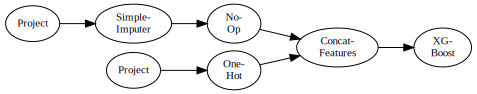

```python
pipeline = XGBoost(
    objective="binary:hinge",
    gamma=0.7014524429360985,
    learning_rate=0.8995774801383642,
    max_depth=1,
    min_child_weight=9,
    n_estimators=143,
    reg_alpha=0.9278242148281716,
    reg_lambda=0.9125332151685732,
    subsample=0.8569518943627816,
)
```

Pareto optimal pipeline p1:


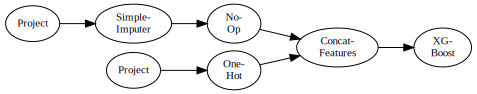

```python
pipeline = XGBoost(
    objective="binary:hinge",
    gamma=0.44334408188180763,
    learning_rate=0.5834474139233724,
    max_depth=1,
    min_child_weight=6,
    n_estimators=104,
    reg_alpha=0.853177497201958,
    reg_lambda=0.5970350696760885,
    subsample=0.01027484726953437,
)
```

Pareto optimal pipeline p2:


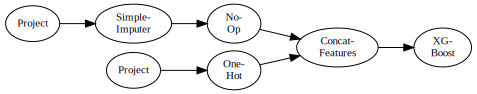

```python
pipeline = XGBoost(
    objective="binary:hinge",
    gamma=0.9847461164216172,
    learning_rate=0.7943499494169831,
    max_depth=7,
    min_child_weight=13,
    n_estimators=566,
    reg_alpha=0.8324041024753753,
    reg_lambda=0.7746616456345864,
    subsample=0.8678230933314245,
)
```

In [14]:
for pname in opt_trained.summary().index:
    print(f"Pareto optimal pipeline {pname}:")
    p = opt_trained.get_pipeline(pname)
    p.visualize()
    p.get_last().pretty_print(ipython_display=True, show_imports=False)

Finally, we plot the Pareto-front for visualization. Here we will generate two plots:

- First, we will plot the Pareto-front of the cross-validated multi-objectives using the pipelines found.
- Then, we will evaluate the multi-objectives of the pipelines found on a held-out test set, and compare these scores to the scores for the pipeline found via single-objective AutoML.

Note that, while the cross-validated multi-objectives will form a Pareto-front, the multi-objectives evaluated on the test scores will not necessarily do the same since the test scores will not generally match the cross-validated scores.

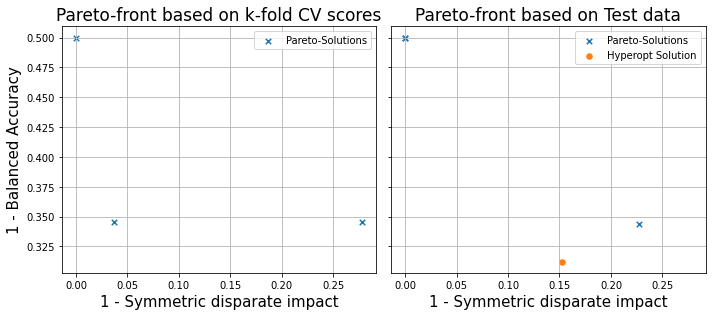

In [15]:
import matplotlib.pyplot as plt
figs, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 4.5), squeeze=True)

pareto_pipelines  = [opt_trained.get_pipeline(pipeline_name=id) for id in opt_trained.summary().index.tolist()]
df_cv = opt_trained.summary()

cols = ['loss1' , 'loss2']
label_dict = {'loss1' : '1 - Balanced Accuracy', 'loss2' : '1 - Symmetric disparate impact'}

# Let's put loss2 on X-axis
ax = axs[0]
ax.scatter(df_cv['loss2'], df_cv['loss1'], s=30, marker='x', label='Pareto-Solutions')
ax.set_xlabel(label_dict['loss2'], fontsize=15)
ax.set_ylabel(label_dict['loss1'], fontsize=15)
ax.grid()
ax.legend()
ax.set_title("Pareto-front based on k-fold CV scores", fontsize=17)

# Let's evaluate the pareto-optimal pipelines on test data
pX, pY = [], []
for pipeline in pareto_pipelines:
    obj1_value = best_score[0] - scorers[0](pipeline, test_X, test_y)
    obj2_value = best_score[1] - scorers[1](pipeline, test_X, test_y)
    
    pX.append(obj1_value)
    pY.append(obj2_value)

dict = {'loss1' : pX, 'loss2' : pY}
df = pd.DataFrame(dict)    
    
# Metric values using single objective best pipeline    
sopt_err = best_score[0] - scorers[0](auto_trained, test_X, test_y)
sopt_fpr = best_score[1] - scorers[1](auto_trained, test_X, test_y)
    
ax = axs[1]
ax.scatter(df['loss2'], df['loss1'], s=30, marker='x', label='Pareto-Solutions')
ax.scatter(sopt_fpr, sopt_err, s=30, marker='o', label='Hyperopt Solution')
ax.set_xlabel(label_dict['loss2'], fontsize=15)
ax.grid()
ax.legend()
ax.set_title("Pareto-front based on Test data", fontsize=17)
plt.tight_layout()
plt.show()